<a href="https://colab.research.google.com/github/ianmazzu/FreecodecampRepository/blob/main/Machinelearning_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
BATCH_SIZE=128
Epochs = 25
IMG_HEIGHT = 150
IMG_WIDTH = 150

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOS

In [3]:
# 3
# Create ImageDataGenerator instances with rescaling (0-255 to 0-1)
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)


train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')


validation_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')


test_data_gen = test_image_generator.flow_from_directory(
    directory=test_dir,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    shuffle=False)                # CRUCIAL: Do not shuffle for the test set

# Note: Based on previous runs, the test generator will likely show "Found 0 images"., problem with flow_from_directory

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


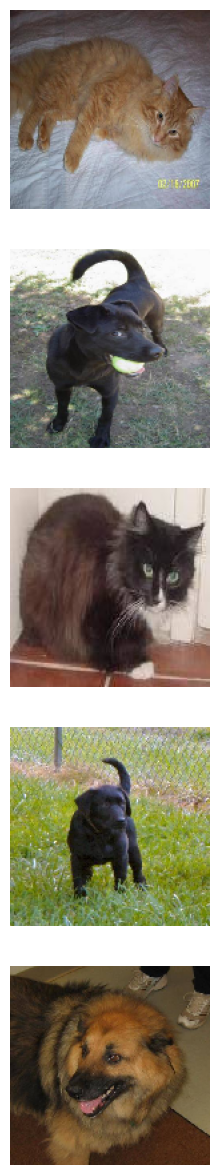

In [4]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [5]:
# 5
# Recreate the train_image_generator with data augmentation
train_image_generator_with_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

print("train_image_generator_with_aug created with successful augmentation parameters.")


train_image_generator_with_aug created with successful augmentation parameters.


Found 2000 images belonging to 2 classes.


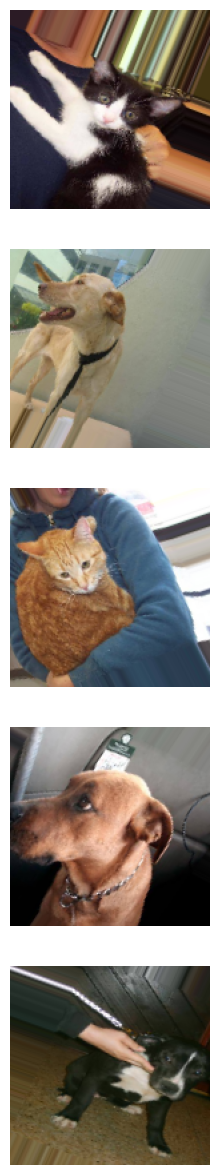

In [7]:
# 6

# Recreate train_data_gen using the augmented image generator
train_data_gen = train_image_generator_with_aug.flow_from_directory(
    directory=train_dir,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')

# Get one batch of augmented training images
augmented_images, _ = next(train_data_gen)
plotImages(augmented_images[:5])


In [ ]:
# 7
# Define the CNN model using Keras Sequential API
model = Sequential([
    # First Convolutional and Pooling Block
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional and Pooling Block
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional and Pooling Block
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the 3D output to 1D for the dense layers
    Flatten(),
    # Fully Connected Layers
    Dense(units=512, activation='relu'),
    # Add Dropout layer here for regularization with the rate that worked well (0.5)
    Dropout(0.45),
    # Output Layer
    Dense(units=1, activation='sigmoid')
])

# Compile the model
# tf.keras.optimizers.Adam(learning_rate=0.000X)
optimizer_to_use = 'adam' # Using default Adam optimizer

model.compile(optimizer=optimizer_to_use,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

In [10]:
# 8

# Calculate steps per epoch and validation steps based on total image counts and batch size
# Use the counts from your Celda 2 output (e.g., total_train, total_val)
steps_per_epoch = total_train // BATCH_SIZE
validation_steps = total_val // BATCH_SIZE

print(f"Steps per epoch calculated: {steps_per_epoch}")
print(f"Validation steps calculated: {validation_steps}")
# Using the number of epochs from your successful run (e.g., 21)
epochs_to_train = Epochs # Use the number of epochs from your successful run

print(f"Starting training for {epochs_to_train} epochs...")

# Train the model
history = model.fit(
    x=train_data_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs_to_train,
    validation_data=validation_data_gen,
    validation_steps=validation_steps
)

print("Training finished.")

Steps per epoch calculated: 15
Validation steps calculated: 7
Starting training for 25 epochs...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5122 - loss: 1.5029 - val_accuracy: 0.4944 - val_loss: 0.7023
Epoch 2/25
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.4922 - loss: 0.7097

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 442ms/step - accuracy: 0.4922 - loss: 0.7097 - val_accuracy: 0.5011 - val_loss: 0.6944
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 947ms/step - accuracy: 0.5160 - loss: 0.6909 - val_accuracy: 0.5703 - val_loss: 0.6860
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.5469 - loss: 0.6889 - val_accuracy: 0.5848 - val_loss: 0.6843
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 956ms/step - accuracy: 0.5481 - loss: 0.6859 - val_accuracy: 0.6049 - val_loss: 0.6574
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.6250 - loss: 0.6660 - val_accuracy: 0.5078 - val_loss: 0.6792
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 964ms/step - accuracy: 0.5463 - loss: 0.6771 - val_accuracy: 0.6161 - val_loss: 0.6377
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.6328 - loss: 0.6717 - val_accuracy: 0.6373 - val_loss: 0.6339
Epoch 9/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 966ms/step - accuracy: 0.5964 - loss: 0.6548 - val_accuracy: 0.5167 - 

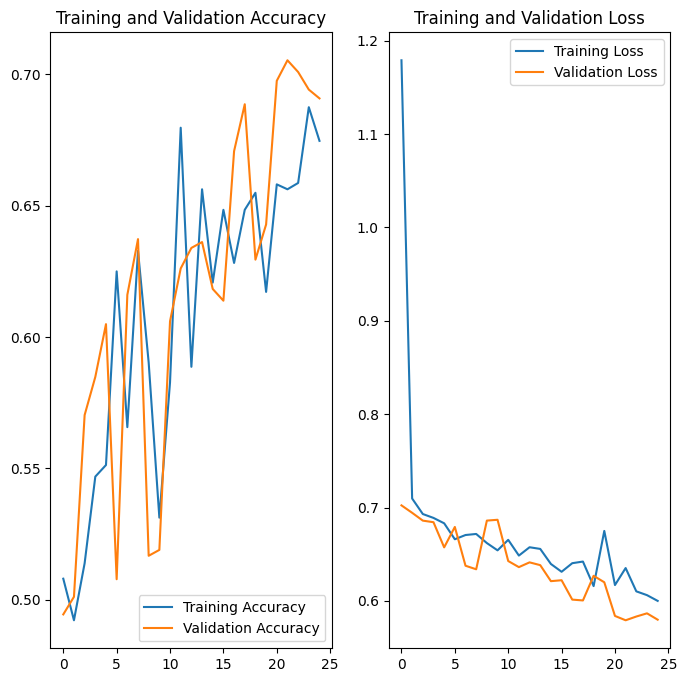

In [13]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(Epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Loading test images manually...
Found 50 test images.
Processed 50 test images into a numpy array.

Plotting a few test images loaded by Celda 10:


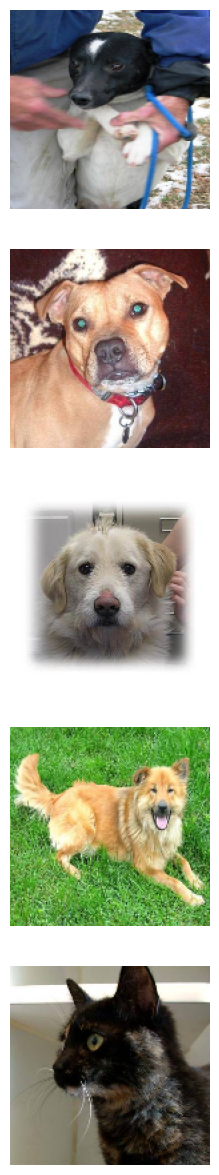

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 672ms/step
Generated 50 predictions (0 or 1).


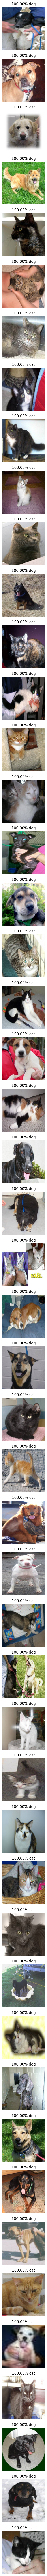

In [14]:
# 10 (MODIFIED - MANUAL TEST DATA LOADING AND PREDICTION)

import glob # To find files matching a pattern
import cv2  # OpenCV for image loading and processing (common in Colab)
# If cv2 is not available, you can use PIL instead: from PIL import Image
import numpy as np # numpy might be needed explicitly if not globally available
import os # Ensure os is imported

print("Loading test images manually...")

# Get the list of all .jpg files in the test directory
# Crucially, sort them by the number in the filename (1.jpg, 2.jpg, ...)
# This is important for the final evaluation cell which expects a specific order.
test_image_paths = sorted(glob.glob(os.path.join(test_dir, '*.jpg')),
                         key=lambda x: int(os.path.basename(x).split('.')[0]))

# Check if we found 50 images
print(f"Found {len(test_image_paths)} test images.")

test_images = []

# Load, resize, and normalize each test image
for img_path in test_image_paths:
    # Load image using OpenCV
    img = cv2.imread(img_path) # Reads image in BGR format by default

    # Convert BGR to RGB format (most models expect RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image to the target size (IMG_HEIGHT, IMG_WIDTH)
    # Note: cv2.resize expects width, height tuple
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

    # Convert image to numpy array and normalize pixel values from [0, 255] to [0, 1]
    img = np.array(img) / 255.0

    test_images.append(img)

# Convert the list of processed images into a single numpy array
test_images_array = np.array(test_images)

print(f"Processed {len(test_images_array)} test images into a numpy array.")
print("\nPlotting a few test images loaded by Celda 10:")
# Plot the first 5 images from the manually loaded test array
plotImages(test_images_array[:5])

# Get the predictions for the test images
# model.predict returns probabilities (0 to 1) for the positive class (dog)
# The output shape will be (num_test_images, 1)
predictions = model.predict(test_images_array)

# Convert probabilities to class labels (0 or 1) based on a 0.5 threshold
# np.round() effectively applies this threshold: <= 0.5 -> 0, > 0.5 -> 1
predictions_classes = np.round(predictions).astype(int)

# The project's final evaluation cell likely expects a list of integers (0 or 1)
# Convert the numpy array of predictions into a flat Python list
probabilities = predictions_classes.flatten().tolist() # flatten makes it 1D, then convert to list

print(f"Generated {len(probabilities)} predictions (0 or 1).")

# Plot the test images with their predicted class label (Cat or Dog)
# The plotImages function will interpret the 0s and 1s as 0% or 100% sure Dog/Cat.
# We pass the test_images_array and the list of integer predictions.
plotImages(test_images_array, probabilities=probabilities)

# Note: The variable 'probabilities' here holds the integer predictions (0 or 1),
# as requested by the project's final evaluation setup.

In [15]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 66.0% of the images of cats and dogs.
You passed the challenge!
